## A notebook for 01-svhn experiment. 
In this notebook, we will show how to setup a dataset, build a graph, train and run a CNN network to implements SVHN(Street View House Numbers) digits classification via tensorflow.

### Configures

In [1]:
minibatch_size = 128  # the number of instances in a batch
nr_channel = 3 # the channels of image
image_shape = (32, 32) # the image shape (height, width)
nr_class = 10 # the number of classes
nr_epoch = 60 # the max epoch of training
weight_decay = 1e-10 # a strength of regularization
test_interval = 5 # test in every ${test_interval} epochs
show_interval = 10 # print a message of training in every ${show_interval} minibatchs 

### Setup a Dataset

In [2]:
# import required modules
import os
import cv2
import numpy as np
from scipy import io as scio

class Dataset():
    dataset_path = '../../dataset/SVHN'  # a path saves dataset
    dataset_meta = {
        'train': ([os.path.join(dataset_path, 'train_32x32.mat')], 73257),
        'test': ([os.path.join(dataset_path, 'test_32x32.mat')], 26032),
    }
    
    def __init__(self, dataset_name):
        self.files, self.instances = self.dataset_meta[dataset_name]
    
    def load(self):
        '''Load dataset metas from files'''
        datas_list, labels_list = [], []
        for f in self.files:
            samples = scio.loadmat(f)
            datas_list.append(samples['X'])
            labels_list.append(samples['y'])
        self.samples = {
            'X': np.concatenate(datas_list, axis=3), # datas
            'Y': np.concatenate(labels_list, axis=0), # labels
        }
        return self

    def instance_generator(self):
        '''a generator to yield a sample'''
        for i in range(self.instances):
            img = self.samples['X'][:, :, :, i]
            label = self.samples['Y'][i, :][0]
            if label == 10:
                label = 0
            img = cv2.resize(img, image_shape)
            yield img.astype(np.float32), np.array(label, dtype=np.int32)
    
    @property
    def instances_per_epoch(self):
        return 25600 # set for a fast experiment
        #return self.instances
    
    @property
    def minibatchs_per_epoch(self):
        return 200 # set for a fast experimetn
        #return self.instances // minibatch_size

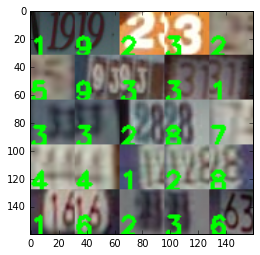

In [3]:
# show an img from dataset
%matplotlib inline
import matplotlib.pyplot as plt

ds = Dataset('train').load()
ds_gen = ds.instance_generator()

imggrid = []
for i in range(25):
    img, label = next(ds_gen) # yield a sample
    cv2.putText(img, str(label), (0, image_shape[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, 
                (0, 255, 0), 2) # put a label on img
    imggrid.append(img) 

# make an img grid from an img list
imggrid = np.array(imggrid).reshape((5, 5, img.shape[0], img.shape[1], img.shape[2]))
imggrid = imggrid.transpose((0, 2, 1, 3, 4)).reshape((5*img.shape[0], 5*img.shape[1], 3)) 
imggrid = cv2.cvtColor(imggrid.astype('uint8'), cv2.COLOR_BGR2RGB)

# show
plt.figure()
plt.imshow(imggrid)
plt.show()

### Build a graph

In [4]:
import tensorflow as tf
import tensorflow.contrib as tf_contrib

class Model():
    '''a class for building a compute graph'''
    
    def __init__(self):
        # set the initializer of conv_weight and conv_bias
        self.weight_init = tf_contrib.layers.variance_scaling_initializer(factor=1.0,
                                mode='FAN_IN', uniform=False)
        self.bias_init = tf.zeros_initializer()
        # set l2 regularizer
        self.reg = tf_contrib.layers.l2_regularizer(weight_decay)

    def _conv_layer(self, name, inp, kernel_shape, stride, padding='SAME',is_training=False):
        '''a conv layer = conv + bn + relu'''
        
        with tf.variable_scope(name) as scope:
            conv_filter = tf.get_variable(name='filter', shape=kernel_shape,
                                          initializer=self.weight_init, regularizer=self.reg)
            conv_bias = tf.get_variable(name='bias', shape=kernel_shape[-1],
                                        initializer=self.bias_init)
            x = tf.nn.conv2d(inp, conv_filter, strides=[1, stride, stride, 1],
                             padding=padding, data_format='NHWC')
            x = tf.nn.bias_add(x, conv_bias, data_format='NHWC')
            x = tf.layers.batch_normalization(x, axis=3, training=is_training)
            x = tf.nn.relu(x)
        return x
    
    def _pool_layer(self, name, inp, ksize, stride, padding='SAME', mode='MAX'):
        '''a pool layer which only supports avg_pooling and max_pooling(default)'''
        
        assert mode in ['MAX', 'AVG'], 'the mode of pool must be MAX or AVG'
        if mode == 'MAX':
            x = tf.nn.max_pool(inp, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1],
                               padding=padding, name=name, data_format='NHWC')
        elif mode == 'AVG':
            x = tf.nn.avg_pool(inp, ksize=[1, ksize, ksize, 1], strides=[1, stride, stride, 1],
                               padding=padding, name=name, data_format='NHWC')
        return x

    def _fc_layer(self, name, inp, units, dropout=0.5):
        '''a full connect layer'''
        
        with tf.variable_scope(name) as scope:
            shape = inp.get_shape().as_list() # get the shape of input
            dim = 1
            for d in shape[1:]:
                dim *= d
            x = tf.reshape(inp, [-1, dim]) # flatten
            if dropout > 0: # if with dropout
                x = tf.nn.dropout(x, keep_prob=dropout, name='dropout')
            x = tf.layers.dense(x, units, kernel_initializer=self.weight_init,
                                bias_initializer=self.bias_init, kernel_regularizer=self.reg)
        return x

    def bulid(self):
        # set inputs
        data = tf.placeholder(tf.float32, shape=(None,)+image_shape+(nr_channel,),
                              name='data')
        label = tf.placeholder(tf.int32, shape=(None,), name='label')
        label_onehot = tf.one_hot(label, nr_class, dtype=tf.int32) 
        is_training = tf.placeholder(tf.bool, name='is_training') # a flag of bn
        
        # conv1
        x = self._conv_layer(name='conv1', inp=data,
                             kernel_shape=[3, 3, nr_channel, 16], stride=1,
                             is_training=is_training) # Nx32x32x32
        x = self._pool_layer(name='pool1', inp=x, ksize=2, stride=2, mode='MAX') # Nx16x16x16

        # conv2
        x = self._conv_layer(name='conv2a', inp=x, kernel_shape=[3, 3, 16, 32],
                             stride=1, is_training=is_training)
        x = self._conv_layer(name='conv2b', inp=x, kernel_shape=[3, 3, 32, 32],
                             stride=1, is_training=is_training)
        x = self._pool_layer(name='pool2', inp=x, ksize=2, stride=2, mode='MAX') # Nx8x8x32
        
        # conv3
        x = self._conv_layer(name='conv3a', inp=x, kernel_shape=[3, 3, 32, 64],
                             stride=1, is_training=is_training)
        x = self._conv_layer(name='conv3b', inp=x, kernel_shape=[3, 3, 64, 64],
                             stride=1, is_training=is_training)
        x = self._pool_layer(name='pool3', inp=x, ksize=2, stride=2, mode='MAX') # Nx4x4x64

        # conv4
        x = self._conv_layer(name='conv4a', inp=x, kernel_shape=[3, 3, 64, 128],
                             stride=1, is_training=is_training)
        x = self._conv_layer(name='conv4b', inp=x, kernel_shape=[3, 3, 128, 128],
                             stride=1, is_training=is_training)
        x = self._pool_layer(name='pool4', inp=x, ksize=4, stride=4, mode='AVG') # Nx1x1x128
        
        # fc
        logits = self._fc_layer(name='fc1', inp=x, units=nr_class, dropout=0)

        placeholders = {
            'data': data,
            'label': label,
            'is_training': is_training,
        }
        return placeholders, label_onehot, logits


### Training

In [5]:
def get_dataset_batch(ds_name):
    '''get a batch generator of dataset'''
    dataset = Dataset(ds_name)
    ds_gnr = dataset.load().instance_generator
    ds = tf.data.Dataset().from_generator(ds_gnr, output_types=(tf.float32, tf.int32),)
    if ds_name == 'train':
        ds = ds.shuffle(dataset.instances_per_epoch)
        ds = ds.repeat(nr_epoch)
    elif ds_name == 'test':
        ds = ds.repeat(nr_epoch // test_interval)
    ds = ds.batch(minibatch_size, drop_remainder=True)
    ds_iter = ds.make_one_shot_iterator()
    sample_gnr = ds_iter.get_next()
    return sample_gnr, dataset

# load datasets
train_batch_gnr, train_set = get_dataset_batch(ds_name='train')
test_batch_gnr, test_set = get_dataset_batch(ds_name='test')

# build a compute graph
network = Model() 
placeholders, label_onehot, logits = network.bulid()
preds = tf.nn.softmax(logits)
loss_reg = tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
loss = tf.losses.softmax_cross_entropy(label_onehot, logits) + loss_reg

# set a performance metric
correct_pred = tf.equal(tf.cast(tf.argmax(preds, 1), dtype=tf.int32),
                        tf.cast(tf.argmax(label_onehot, 1), dtype=tf.int32))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# learn rate config
global_steps = tf.Variable(0, trainable=False) # a cnt to record the num of minibatchs
boundaries = [train_set.minibatchs_per_epoch*15, train_set.minibatchs_per_epoch*40] 
values = [0.01, 0.001, 0.0005]
lr = tf.train.piecewise_constant(global_steps, boundaries, values)

opt = tf.train.AdamOptimizer(lr) # use adam as optimizer

# in order to update BN in every iter, a trick in tf
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train = opt.minimize(loss)

In [6]:
# create a session
tf.set_random_seed(12345) # ensure consistent results
global_cnt = 0 # a cnt to record the num of minibatchs

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # init all variables
    # training
    for e in range(nr_epoch): 
        for _ in range(train_set.minibatchs_per_epoch):
            global_cnt += 1
            images, labels = sess.run(train_batch_gnr) # get a batch of (img, label)
            feed_dict = { # assign data to placeholders respectively
                    placeholders['data']: images,
                    placeholders['label']: labels,
                    global_steps: global_cnt,
                    placeholders['is_training']: True, # in training phase, set True
            }
            # run train, and output all values you want to monitor
            _, loss_v, acc_v, lr_v = sess.run([train, loss, accuracy, lr], 
                                              feed_dict=feed_dict)
            
            if global_cnt % show_interval == 0:
                print(
                    "e:{},{}/{}".format(e, global_cnt % train_set.minibatchs_per_epoch,
                                        train_set.minibatchs_per_epoch),
                    'loss: {:.3f}'.format(loss_v),
                    'acc: {:.3f}'.format(acc_v),
                    'lr: {:.3f}'.format(lr_v),
                )

    # validation
    if epoch % test_interval == 0:
        loss_sum, acc_sum = 0, 0 # init
        for i in range(test_set.minibatchs_per_epoch):
            images, labels = sess.run(test_batch_gnr)
            feed_dict = {
                    placeholders['data']: images,
                    placeholders['label']: labels,
                    global_steps: global_cnt,
                    placeholders['is_training']: False, # in test phase, set False
                }
            loss_v, acc_v = sess.run([loss, accuracy], feed_dict=feed_dict)
            loss_sum += loss_v # update
            acc_sum += acc_v # update
        print("\n**************Validation results****************")
        print('loss_avg: {:.3f}'.format(loss_sum / test_set.minibatchs_per_epoch),
              'accuracy_avg: {:.3f}'.format(acc_sum / test_set.minibatchs_per_epoch))
        print("************************************************\n")    

print('Training is done, exit.')

e:0,10/200 loss: 2.325 acc: 0.180 lr: 0.010
e:0,20/200 loss: 2.244 acc: 0.203 lr: 0.010
e:0,30/200 loss: 2.242 acc: 0.195 lr: 0.010
e:0,40/200 loss: 2.248 acc: 0.211 lr: 0.010
e:0,50/200 loss: 2.317 acc: 0.180 lr: 0.010
e:0,60/200 loss: 2.233 acc: 0.219 lr: 0.010


KeyboardInterrupt: 